## Age Based on Image Regressor

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
from scipy.io import loadmat
from datetime import datetime

Dataset from https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
@article{Rothe-IJCV-2016,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {Deep expectation of real and apparent age from a single image without facial landmarks},
  journal = {International Journal of Computer Vision (IJCV)},
  year = {2016},
  month = {July},
}

Age extraction code based on https://github.com/yu4u/age-gender-estimation

In [6]:
path = Path('data/ages/wiki_crop')

In [7]:
def calc_age(taken, dob):
    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    # assume the photo was taken in the middle of the year
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [8]:
mat_path = path/'wiki.mat'

In [9]:
meta = loadmat(mat_path)

In [10]:
dob = meta['wiki'][0, 0]["dob"][0]  # Matlab serial date number

In [11]:
dob

array([723671, 703186, 711677, 705061, ..., 711338, 720620, 723893, 713846], dtype=int32)

In [12]:
photo_taken = meta['wiki'][0, 0]["photo_taken"][0]  # year

In [13]:
age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]

In [14]:
len(age)

62328

In [15]:
pic_path = meta['wiki'][0, 0]["full_path"][0]

In [16]:
str(pic_path[0])

"['17/10000217_1981-05-05_2009.jpg']"

In [17]:
all_paths = [str(pic[0]) for pic in pic_path]

In [18]:
all_paths[0]

'17/10000217_1981-05-05_2009.jpg'

In [19]:
type(pic_path[0])

numpy.ndarray

In [20]:
tester = 24

In [21]:
test_path = str(pic_path[tester][0]); age[tester]

28

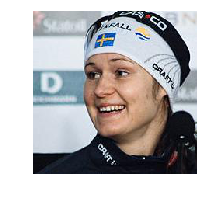

In [22]:
fname = path/test_path
img = open_image(fname)
img.show()

In [174]:
img.size

torch.Size([211, 211])

In [23]:
labels = pd.DataFrame(all_paths, columns=['fn_col'])

In [24]:
labels['label_col'] = age

In [25]:
labels.head()

,fn_col,label_col
0,17/10000217_1981-05-05_2009.jpg,28
1,48/10000548_1925-04-04_1964.jpg,39
2,12/100012_1948-07-03_2008.jpg,59
3,65/10001965_1930-05-23_1961.jpg,31
4,16/10002116_1971-05-31_2012.jpg,41


28

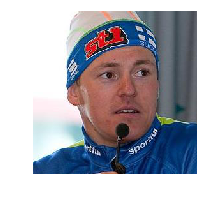

In [26]:
item_index = 0
img = open_image(path/labels['fn_col'][item_index])
img.show(); labels['label_col'][item_index]

In [27]:
data = (ImageFileList.from_folder(path, extensions='.jpg')
        .label_from_df(labels, fn_col='fn_col', label_col='label_col')
        .random_split_by_pct() 
        .datasets()
        .transform(get_transforms(), size=128)
        .databunch().normalize(imagenet_stats)
       )

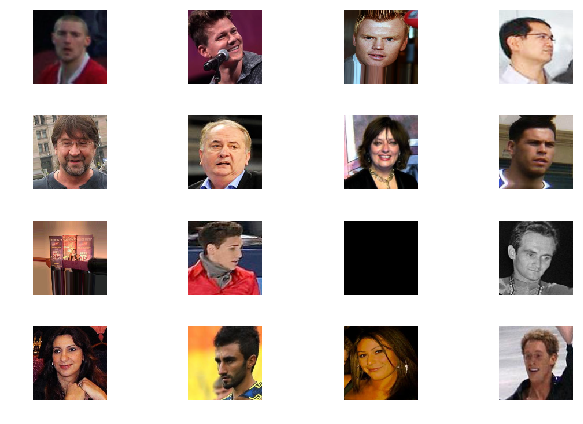

In [182]:
data.show_batch(4, figsize=(9,6))

In [37]:
learn = create_cnn(data, models.resnet34, metrics=exp_rmspe)
learn.loss_func = MSELossFlat()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


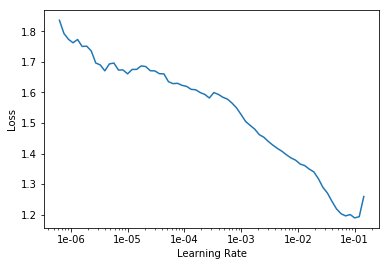

In [184]:
learn.lr_find()
learn.recorder.plot()

In [33]:
lr = 2e-2

In [38]:
learn.fit_one_cycle(5, slice(lr))

Total time: 07:28
epoch  train_loss  valid_loss  exp_rmspe
1      0.003205    0.001625    0.037204   (01:33)
2      0.000545    0.000407    0.011003   (01:28)
3      0.000793    0.000620    0.016701   (01:29)
4      0.000021    0.000324    0.002563   (01:29)
5      0.000391    0.014509    0.003427   (01:29)



In [39]:
learn.save('age-stage-1')

In [191]:
doc(Learner)

In [40]:
learn.get_preds()

[tensor([[0.0000],
         [0.0001],
         [0.0000],
         ...,
         [0.0007],
         [0.0003],
         [0.0001]]), tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]])]

In [41]:
learn.validate()

[0.014508679, tensor(0.0034)]

In [45]:
   def my_predict(learner, img:Image):
        ds = learner.data.valid_ds
        ds.set_item(img)
        res = learner.pred_batch()[0]
        ds.clear_item()
        return res

In [46]:
my_predict(learn, img)

tensor([0.0002])

In [47]:
learn.get_preds(with_loss=True)

[tensor([[0.0000],
         [0.0001],
         [0.0000],
         ...,
         [0.0007],
         [0.0003],
         [0.0001]]), tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]), tensor([1.8650e-09, 4.1774e-09, 2.5000e-09,  ..., 4.3660e-07, 1.2133e-07,
         1.2679e-08])]